## Preamble

In [1]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline



## Modified Alveoli model

+ We treat each alveolus as a bistable system with two states: open and closed.
+ We couple the alveoli with a network of springs, which encourage adjacent alveoli to be in the same state.
+ We define the network to have a tree-like geometry

https://link.springer.com/chapter/10.1007/0-387-27023-X_44


Text(0, 0.5, 'Alveoli radius')

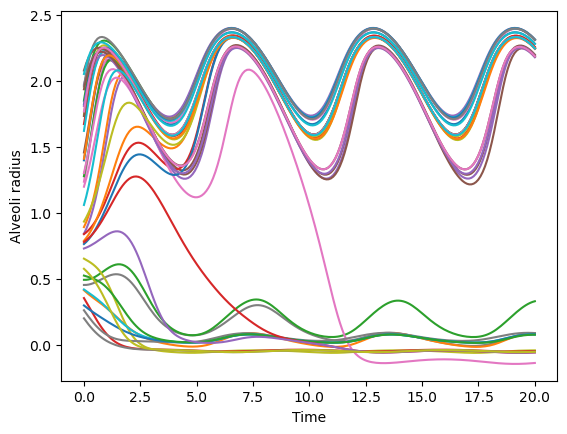

In [29]:

from scipy.integrate import solve_ivp


def tree_coupling_matrix(n):
    """
    Create a tree-like adjacency matrix for n nodes. The first node is the root.

    Args:
        n (int): number of nodes
        
    Returns:
        matrix (ndarray): n x n coupling matrix

    """
    if n < 1:
        return "n should be greater than or equal to 1"
    
    # Initialize an n x n matrix with zeros
    matrix = np.zeros((n, n), dtype=int)
    
    # Create tree-like connections
    for i in range(1, n):
        matrix[i, (i-1)//2] = 1
        matrix[(i-1)//2, i] = 1
    
    return matrix

class AlveoliModel:
    """
    The cubic term represents a nonlinear elastic response
    Bistability: collapsed state and open state

    CRPG: pattern generator
    Alveoli model: elastic response function

    Attributes:
        alpha (float or ndarray): the stiffness of the elastic response
        beta (float or ndarray): the nonlinear stiffness of the elastic response
        omega (float or ndarray): the frequency of the forcing
        gamma (float or ndarray): the amplitude of the forcing
        k (float or ndarray): the coupling among alveoli
    """

    def __init__(self, k=1, alpha=1, beta=1, omega=1, gamma=0.1):
        self.alpha = alpha
        self.beta = beta
        self.omega = omega
        self.gamma = gamma
        self.k = k
        self.rc = np.sqrt(self.beta / self.alpha)

    def rhs(self, t, X):
        r = X
        # zdot = self.omega
        # force = self.gamma * np.cos(z)
        force = self.gamma * np.cos(self.omega *t)
        rs = r - self.rc
        rdot = 0 
        rdot = 0.1 * force  * r # forcing term
        rdot += -self.alpha * rs ** 3 + self.beta * rs # elastic response
        rdot += self.k @ rs # coupling

        return np.array(rdot)
    
    def solve(self, t, X0):
        self.t = t
        self.X0 = X0
        self.sol = solve_ivp(self.rhs, (t[0], t[-1]), X0, t_eval=t, method='Radau')
        return self.sol

# No forcing
# eq = AlveoliModel(gamma=0)

n_nodes = 40

np.random.seed(10)
k = 0.1 * (np.random.random((n_nodes, n_nodes)))
k = 0.1 * tree_coupling_matrix(n_nodes)
eq = AlveoliModel(gamma=4, k=k)

t = np.linspace(0, 20, 200)
X0 = 2.1 * np.random.random(k.shape[0])
sol = eq.solve(t, X0)

# plt.figure()
# plt.plot(sol.y[0, :], sol.y[1, :])

plt.figure()
plt.plot(sol.t, sol.y[:, :].T)
plt.xlabel('Time')
plt.ylabel('Alveoli radius')

## Plot snapshots of the network at several timepoints

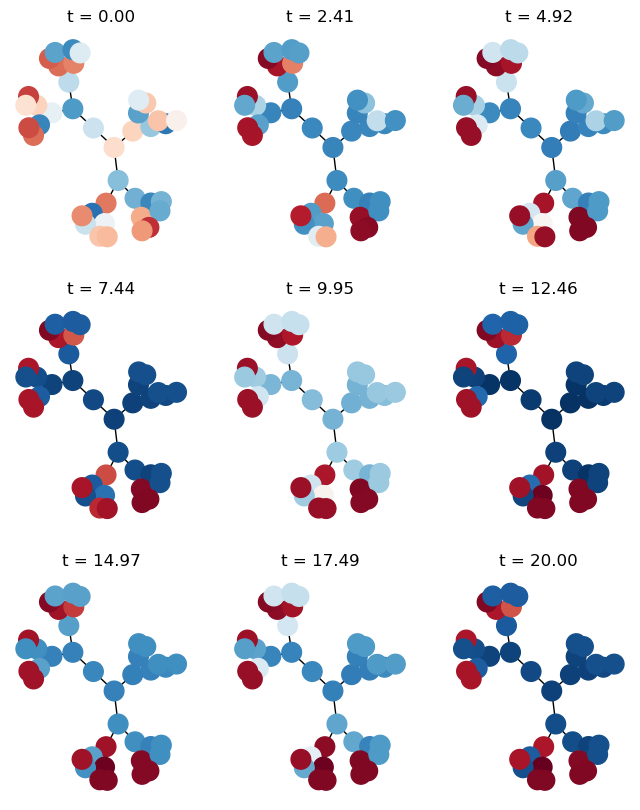

In [3]:
import networkx as nx

# from networkx.drawing.nx_agraph import graphviz_layout

def plot_tree(n, nodecolors=None, pos=None, random_state=None, ax=None, **kwargs):
    """
    Given a balanced tree coupling matrix, plot the tree with matplotlib
    """
    # Get the adjacency matrix
    matrix = tree_coupling_matrix(n)
    
    # Create a graph from the adjacency matrix
    G = nx.Graph(matrix)
    
    if pos is None:
        # Create a tree layout for our graph
        # pos = nx.tree_layout(G)
        pos = nx.spring_layout(G, iterations=100, seed=random_state)
        # pos = graphviz_layout(G, prog="twopi")

    if nodecolors is None:
        nodecolors = np.random.random(n)

    nx.draw(G, pos, with_labels=False, node_size=200, node_color=nodecolors, ax=ax, vmin=0, vmax=1, **kwargs)
    
    # Draw the graph
    # nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue")
    
    # # Show the plot
    # plt.show()

    return pos



n_plots = 9

plot_time_inds = np.linspace(0, sol.y.shape[1]-1, n_plots).astype(int)
phases = sol.y
phases = (phases - phases.min()) / (phases.max() - phases.min()) # normalize to [0, 1]

# 3 x 3 grid of plots
fig, axs = plt.subplots(3, 3, figsize=(8, 10))
for i, ax in enumerate(axs.flatten()):
    if i == 0:
        pos = plot_tree(n_nodes, nodecolors=phases[:, plot_time_inds[i]], ax=ax, cmap="RdBu", random_state=0)
    else:
        pos = plot_tree(n_nodes, nodecolors=phases[:, plot_time_inds[i]], pos=pos, ax=ax, cmap="RdBu")
    # label time
    ax.set_title(f"t = {sol.t[plot_time_inds[i]]:.2f}")



# Place alveoli on the leaves of a tree graph

+ Issue: mean field dominates, once a majority are open all will open. Conversely, once a majority are closed all will close.
+ What destabilizes mean field? Feedback where when some close, the pressure on the remaining ones increases, causing them to open

In [10]:


def weighted_shortest_distance(n):
    depth = int(np.log2(n))
    total_nodes = 2**depth - 1
    leaf_indices = [total_nodes + i for i in range(n)]

    matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            xi, xj = leaf_indices[i], leaf_indices[j]
            distance = 0

            while xi != xj:
                if xi > xj:
                    xi = (xi - 1) // 2
                else:
                    xj = (xj - 1) // 2
                distance += 2
            
            matrix[i, j] = distance
            matrix[j, i] = distance

    return matrix

def hyperbolic_coupling_matrix(n):
    a = weighted_shortest_distance(n)
    np.fill_diagonal(a, np.inf)
    a = 1 / a
    np.fill_diagonal(a, 0)
    return a / np.sum(a)

# You can use the following command to render the matrix in a readable way
# np.set_printoptions(linewidth=np.inf)





Text(0, 0.5, 'Alveoli radius')

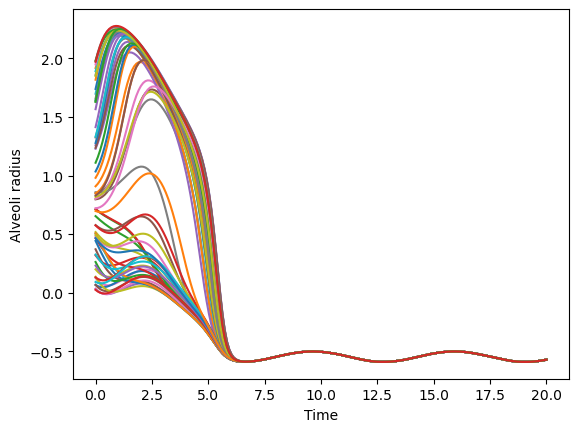

In [67]:
# k = 0.1 * tree_coupling_matrix(n_nodes)
a = 2 * hyperbolic_coupling_matrix(64)
a = 0.1 * a / np.max(a, axis=1, keepdims=True)

k = a
n_nodes = a.shape[0]
eq = AlveoliModel(gamma=4, k=k)

t = np.linspace(0, 20, 200)
# np.random.seed(0)
X0 = 2.0 * np.random.random(k.shape[0])
sol = eq.solve(t, X0)

# plt.figure()
# plt.plot(sol.y[0, :], sol.y[1, :])

plt.figure()
plt.plot(sol.t, sol.y[:, :].T)
plt.xlabel('Time')
plt.ylabel('Alveoli radius')

# Work on stochastic recruitment

+ This requires simulating an SDE, and is not yet working
+ Idea: rather than adding noise to the dynamics, stochastically vary the barrier height between open and closed states

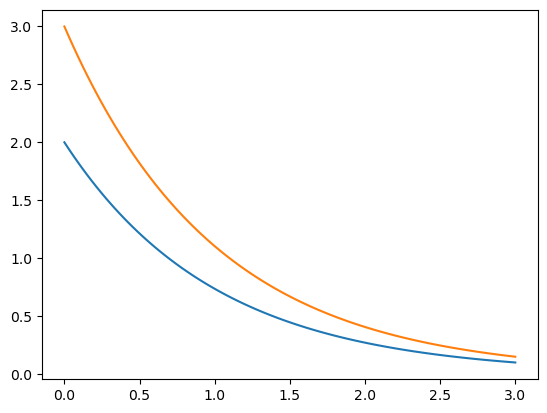

In [44]:
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt
import jax.numpy as jnp

def f(t, y, args):
    return -y

tmax = 3

term = ODETerm(f)
solver = Dopri5()
y0 = jnp.array([2., 3.])
t_store = SaveAt(ts=np.linspace(0, tmax, 100))
sol = diffeqsolve(term, solver, t0=0, t1=tmax, dt0=0.1, y0=y0, saveat=t_store)


# print(sol.ts)  # DeviceArray([0.   , 1.   , 2.   , 3.    ])
# print(sol.ys)

plt.plot(sol.ts, sol.ys)
